In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import time
import matplotlib.pyplot as plt


In [2]:
emb_df = pd.read_csv("../task-02/test_embeddings_w2v.tsv", sep="\t", header=None)

print(emb_df.shape)
emb_df.head()


(7600, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0,0.065897,0.063292,-0.010164,0.158007,0.031801,-0.041949,-0.004342,0.193236,-0.051720,...,0.094232,-0.088833,0.045131,0.075881,0.052591,0.080186,0.120267,-0.224953,0.057195,0.037297
1,1,0.028763,0.200853,0.010623,0.088575,-0.105156,-0.017585,0.058023,0.191611,-0.107521,...,0.195384,-0.111954,0.149213,0.071622,-0.006434,0.049836,0.112595,-0.262420,0.017403,0.089892
2,2,-0.104089,0.087283,0.015381,0.148043,-0.070682,-0.058459,0.050382,0.195593,-0.116890,...,0.160328,-0.114294,0.163771,0.101698,0.015353,0.019159,0.039084,-0.182854,0.005598,-0.013240
3,3,-0.002577,0.154918,0.045293,0.174643,-0.068517,-0.086111,0.003665,0.245695,-0.131139,...,0.060830,-0.050322,0.119443,0.095019,0.035846,0.000980,0.068263,-0.204584,0.005327,0.023124
4,4,0.026991,0.096602,-0.014040,0.102226,-0.045222,-0.015442,0.001601,0.184406,-0.079341,...,0.135423,-0.077574,0.120717,0.065995,0.049589,0.036172,0.039354,-0.116037,0.033504,0.021278


In [3]:

test_df = pd.read_csv("../task-01/data/test.csv", header=None)

X = emb_df.iloc[:, 1:].values

y = test_df.iloc[:, 0].values

print("X:", X.shape)
print("y:", y.shape)


X: (7600, 100)
y: (7600,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("train:", X_train.shape, y_train.shape)
print("test :", X_test.shape, y_test.shape)


train: (6080, 100) (6080,)
test : (1520, 100) (1520,)


In [5]:
import numpy as np

def compute_confusion(y_true, y_pred):
    labels = np.unique(np.concatenate([y_true, y_pred]))
    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    K = len(labels)
    cm = np.zeros((K, K), dtype=int)
    for yt, yp in zip(y_true, y_pred):
        i = label_to_idx[yt]
        j = label_to_idx[yp]
        cm[i, j] += 1
    return cm, labels


def compute_metrics(y_true, y_pred):
    cm, labels = compute_confusion(y_true, y_pred)
    K = len(labels)

    total = cm.sum()
    correct = np.trace(cm)
    accuracy = correct / total
    error_rate = 1.0 - accuracy

    TP = np.trace(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)

    micro_precision = TP / (TP + FP.sum() + 1e-12)
    micro_recall = TP / (TP + FN.sum() + 1e-12)
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + 1e-12)

    precisions = []
    recalls = []
    f1s = []

    for i in range(K):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        prec = tp / (tp + fp + 1e-12)
        rec = tp / (tp + fn + 1e-12)
        f1 = 2 * prec * rec / (prec + rec + 1e-12)

        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    macro_precision = float(np.mean(precisions))
    macro_recall = float(np.mean(recalls))
    macro_f1 = float(np.mean(f1s))

    return {
        "accuracy": float(accuracy),
        "error_rate": float(error_rate),
        "micro_f1": float(micro_f1),
        "macro_f1": float(macro_f1),
        "macro_precision": float(macro_precision),
        "macro_recall": float(macro_recall),
    }


In [6]:
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
import time
import warnings

def train_and_evaluate_svm(
    X_train, y_train, X_test, y_test,
    kernel="linear", C=1.0, gamma="scale", max_iter=5000
):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf = SVC(
            kernel=kernel,
            C=C,
            gamma=gamma,
            max_iter=max_iter,
            tol=1e-3,
            decision_function_shape="ovr"
        )

        start_time = time.time()
        clf.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time

    y_pred = clf.predict(X_test_scaled)
    metrics = compute_metrics(y_test, y_pred)
    metrics["train_time"] = train_time
    metrics["kernel"] = kernel
    metrics["max_iter"] = max_iter

    return clf, metrics


In [7]:
results = []

kernels = ["linear", "rbf"]
iters_list = [100, 500, 750, 1000, 1500, 2000, 5000]

for kernel in kernels:
    for iters in iters_list:
        print(f"=== kernel={kernel}, max_iter={iters} ===")
        clf, m = train_and_evaluate_svm(
            X_train, y_train, X_test, y_test,
            kernel=kernel,
            max_iter=iters
        )
        results.append(m)

df_results = pd.DataFrame(results)
df_results


=== kernel=linear, max_iter=100 ===
=== kernel=linear, max_iter=500 ===
=== kernel=linear, max_iter=750 ===
=== kernel=linear, max_iter=1000 ===
=== kernel=linear, max_iter=1500 ===
=== kernel=linear, max_iter=2000 ===
=== kernel=linear, max_iter=5000 ===
=== kernel=rbf, max_iter=100 ===
=== kernel=rbf, max_iter=500 ===
=== kernel=rbf, max_iter=750 ===
=== kernel=rbf, max_iter=1000 ===
=== kernel=rbf, max_iter=1500 ===
=== kernel=rbf, max_iter=2000 ===
=== kernel=rbf, max_iter=5000 ===


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter
0,0.399342,0.600658,0.399342,0.395352,0.405999,0.399342,0.357783,linear,100
1,0.432237,0.567763,0.432237,0.435232,0.445875,0.432237,1.494017,linear,500
2,0.424342,0.575658,0.424342,0.421426,0.421390,0.424342,1.904448,linear,750
3,0.344737,0.655263,0.344737,0.346006,0.348768,0.344737,1.610847,linear,1000
4,0.418421,0.581579,0.418421,0.414780,0.415142,0.418421,1.401247,linear,1500
5,0.446053,0.553947,0.446053,0.447811,0.455025,0.446053,1.974424,linear,2000
6,0.497368,0.502632,0.497368,0.493965,0.495411,0.497368,2.827391,linear,5000
7,0.459211,0.540789,0.459211,0.449683,0.478952,0.459211,0.393657,rbf,100
8,0.718421,0.281579,0.718421,0.717626,0.718811,0.718421,1.585529,rbf,500
9,0.747368,0.252632,0.747368,0.746458,0.749324,0.747368,2.297532,rbf,750


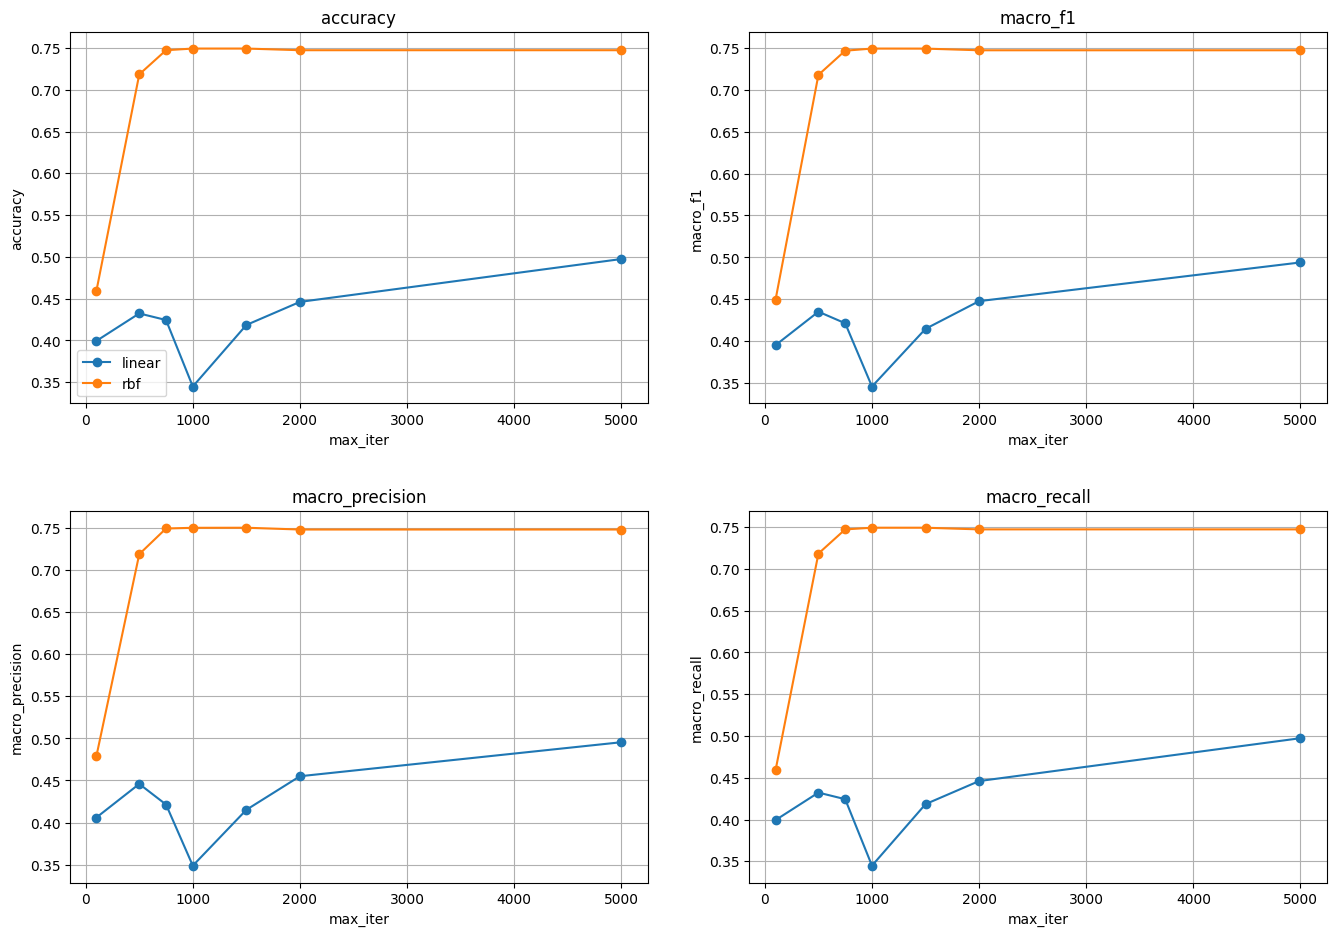

In [24]:
import matplotlib.pyplot as plt

metrics_to_plot = ["accuracy", "macro_f1", "macro_precision", "macro_recall"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten() 

for i, metric in enumerate(metrics_to_plot):
    ax = axs[i]
    for kernel in kernels:
        subset = df_results[df_results["kernel"] == kernel]
        ax.plot(subset["max_iter"], subset[metric], marker="o", label=kernel)
    
    ax.set_xlabel("max_iter")
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.grid(True)

    if i == 0:
        ax.legend()

plt.tight_layout(pad=3.0)
plt.show()

In [9]:
best = df_results.sort_values("macro_f1", ascending=False).iloc[0]
best


accuracy           0.749342
error_rate         0.250658
micro_f1           0.749342
macro_f1           0.748994
macro_precision    0.750132
macro_recall       0.749342
train_time         2.512493
kernel                  rbf
max_iter               1000
Name: 10, dtype: object

In [10]:
best_kernel = best["kernel"]
best_max_iter = int(best["max_iter"])

np.random.seed(42)

dims_to_keep = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]

dim_results = []

for d in dims_to_keep:
    print(f"\n=== Размерность {d} ===")
    
    idx = np.random.choice(X_train.shape[1], size=d, replace=False)
    
    X_train_sub = X_train[:, idx]
    X_test_sub  = X_test[:, idx]
    
    _, m = train_and_evaluate_svm(
        X_train_sub, y_train,
        X_test_sub,  y_test,
        kernel=best_kernel,
        max_iter=best_max_iter
    )
    m["dim"] = d
    dim_results.append(m)

df_dim = pd.DataFrame(dim_results).sort_values("dim", ascending=False)
df_dim



=== Размерность 100 ===

=== Размерность 90 ===

=== Размерность 80 ===

=== Размерность 70 ===

=== Размерность 60 ===

=== Размерность 50 ===

=== Размерность 40 ===

=== Размерность 30 ===

=== Размерность 20 ===

=== Размерность 10 ===


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter,dim
0,0.749342,0.250658,0.749342,0.748994,0.750132,0.749342,3.272275,rbf,1000,100
1,0.742763,0.257237,0.742763,0.742263,0.743622,0.742763,2.085178,rbf,1000,90
2,0.733553,0.266447,0.733553,0.732203,0.732908,0.733553,1.527660,rbf,1000,80
3,0.731579,0.268421,0.731579,0.731477,0.733508,0.731579,1.686021,rbf,1000,70
4,0.712500,0.287500,0.712500,0.712129,0.713927,0.712500,2.302880,rbf,1000,60
5,0.707895,0.292105,0.707895,0.707193,0.708600,0.707895,1.190637,rbf,1000,50
6,0.681579,0.318421,0.681579,0.680101,0.680299,0.681579,1.267260,rbf,1000,40
7,0.661842,0.338158,0.661842,0.660799,0.664078,0.661842,1.227158,rbf,1000,30
8,0.621711,0.378289,0.621711,0.621597,0.622761,0.621711,1.045112,rbf,1000,20
9,0.532237,0.467763,0.532237,0.530074,0.537939,0.532237,0.897331,rbf,1000,10


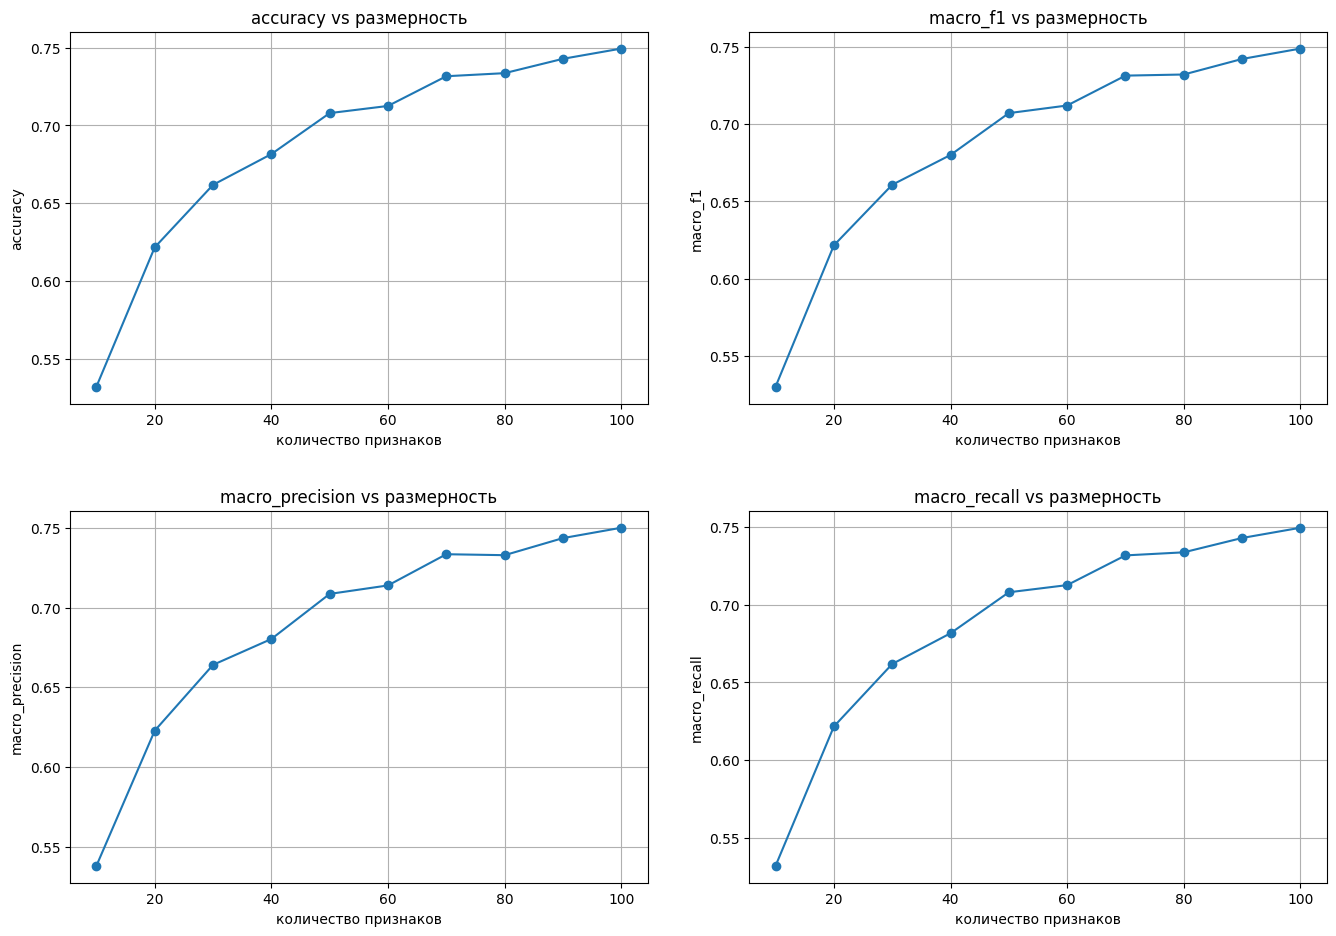

In [25]:
import matplotlib.pyplot as plt

metrics_to_plot = ["accuracy", "macro_f1", "macro_precision", "macro_recall"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axs[i]
    ax.plot(df_dim["dim"], df_dim[metric], marker="o", linestyle="-", color="tab:blue")
    
    ax.set_xlabel("количество признаков")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs размерность")
    ax.grid(True)

plt.tight_layout(pad=3.0)
plt.show()

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

best_kernel = best["kernel"]
best_max_iter = int(best["max_iter"])

dims_to_keep = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]

pca_results = []

for d in dims_to_keep:
    print(f"\n=== PCA компоненты: {d} ===")

    # Важно: scaler + PCA фитим ТОЛЬКО на train, test только transform
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=d, random_state=42))
    ])

    X_train_pca = pipe.fit_transform(X_train)   # fit только на train
    X_test_pca  = pipe.transform(X_test)        # transform на test

    # обучение/оценка твоей функцией
    _, m = train_and_evaluate_svm(
        X_train_pca, y_train,
        X_test_pca,  y_test,
        kernel=best_kernel,
        max_iter=best_max_iter
    )

    # доп. инфа (полезно для отчёта)
    m["dim"] = d
    m["pca_explained_var"] = float(pipe.named_steps["pca"].explained_variance_ratio_.sum())
    pca_results.append(m)

df_pca = pd.DataFrame(pca_results).sort_values("dim", ascending=False)
df_pca



=== PCA компоненты: 100 ===

=== PCA компоненты: 90 ===

=== PCA компоненты: 80 ===

=== PCA компоненты: 70 ===

=== PCA компоненты: 60 ===

=== PCA компоненты: 50 ===

=== PCA компоненты: 40 ===

=== PCA компоненты: 30 ===

=== PCA компоненты: 20 ===

=== PCA компоненты: 10 ===


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter,dim,pca_explained_var
0,0.759868,0.240132,0.759868,0.760063,0.761458,0.759868,5.126964,rbf,1000,100,1.000000
1,0.748026,0.251974,0.748026,0.747500,0.748324,0.748026,3.746131,rbf,1000,90,0.987455
2,0.750000,0.250000,0.750000,0.749389,0.749723,0.750000,2.624819,rbf,1000,80,0.969547
3,0.756579,0.243421,0.756579,0.755999,0.756275,0.756579,2.730120,rbf,1000,70,0.946548
4,0.748684,0.251316,0.748684,0.748313,0.749068,0.748684,1.632203,rbf,1000,60,0.918104
5,0.748026,0.251974,0.748026,0.747571,0.748643,0.748026,1.176396,rbf,1000,50,0.882483
6,0.738158,0.261842,0.738158,0.736921,0.737857,0.738158,1.205396,rbf,1000,40,0.837221
7,0.718421,0.281579,0.718421,0.717466,0.717845,0.718421,1.287563,rbf,1000,30,0.779114
8,0.702632,0.297368,0.702632,0.702120,0.703908,0.702632,0.962612,rbf,1000,20,0.697124
9,0.673684,0.326316,0.673684,0.673056,0.676409,0.673684,0.699149,rbf,1000,10,0.566383


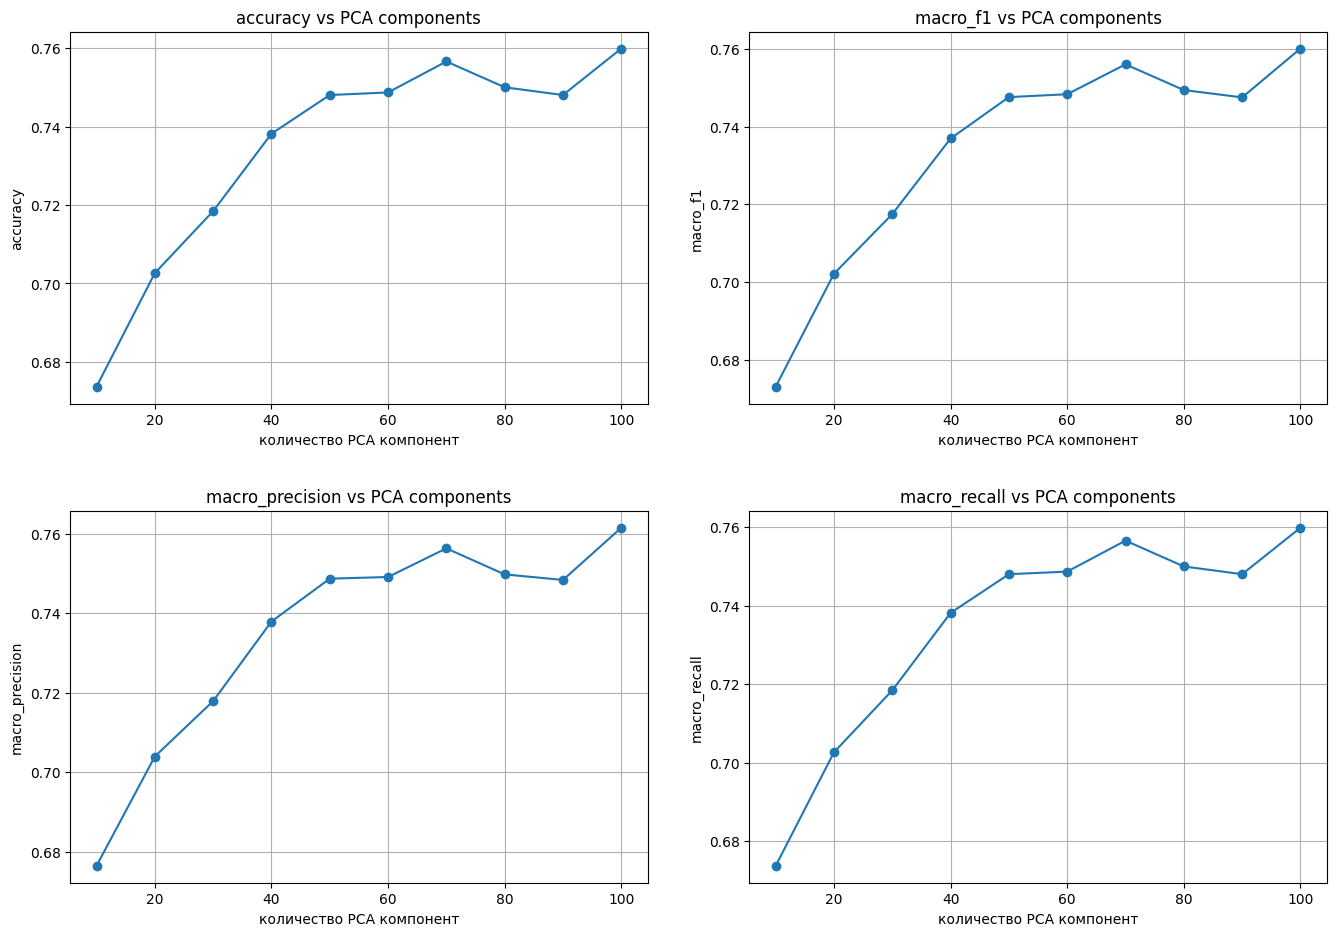

In [26]:
import matplotlib.pyplot as plt

metrics_to_plot = ["accuracy", "macro_f1", "macro_precision", "macro_recall"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axs[i]
    ax.plot(df_pca["dim"], df_pca[metric], marker="o", linestyle="-", color="tab:blue")
    
    ax.set_xlabel("количество PCA компонент")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs PCA components")
    ax.grid(True)

plt.tight_layout(pad=3.0)
plt.show()

In [12]:

print(f"Используем лучшую модель: kernel={best_kernel}, max_iter={best_max_iter}")

def add_math_features(X):

    new_features = []
    

    X_mean = np.mean(X, axis=1, keepdims=True)
    X_std = np.std(X, axis=1, keepdims=True)
    X_max = np.max(X, axis=1, keepdims=True)
    X_min = np.min(X, axis=1, keepdims=True)
    
    new_features.append(np.abs(X_mean))
    
    new_features.append(np.sqrt(np.abs(X_mean) + 1e-8))
    
    new_features.append(np.log(np.abs(X_mean) + 1))
    
    new_features.append(np.cos(X_mean))
    new_features.append(np.sin(X_mean))
    
    new_features.append(X_std)
    
    new_features.append(X_max - X_min)
    
    new_features.append(X_mean ** 2)
    
    X_mean_norm = (X_mean - X_mean.min()) / (X_mean.max() - X_mean.min() + 1e-8)
    new_features.append(np.exp(X_mean_norm * 2 - 1))
    
    return np.hstack([X] + new_features)

feature_configs = [
    {"name": "Базовые (без доп. признаков)", "func": lambda X: X},
    {"name": "abs + sqrt", "func": lambda X: np.hstack([
        X,
        np.abs(np.mean(X, axis=1, keepdims=True)),
        np.sqrt(np.abs(np.mean(X, axis=1, keepdims=True)) + 1e-8)
    ])},
    {"name": "abs + sqrt + log", "func": lambda X: np.hstack([
        X,
        np.abs(np.mean(X, axis=1, keepdims=True)),
        np.sqrt(np.abs(np.mean(X, axis=1, keepdims=True)) + 1e-8),
        np.log(np.abs(np.mean(X, axis=1, keepdims=True)) + 1)
    ])},
    {"name": "abs + sqrt + log + cos + sin", "func": lambda X: np.hstack([
        X,
        np.abs(np.mean(X, axis=1, keepdims=True)),
        np.sqrt(np.abs(np.mean(X, axis=1, keepdims=True)) + 1e-8),
        np.log(np.abs(np.mean(X, axis=1, keepdims=True)) + 1),
        np.cos(np.mean(X, axis=1, keepdims=True)),
        np.sin(np.mean(X, axis=1, keepdims=True))
    ])},
    {"name": "Все функции", "func": add_math_features},
]

math_results = []

for config in feature_configs:
    print(f"\n=== {config['name']} ===")
    
    X_train_extended = config["func"](X_train)
    X_test_extended = config["func"](X_test)
    
    print(f"Размерность: {X_train_extended.shape[1]}")
    
    _, m = train_and_evaluate_svm(
        X_train_extended, y_train,
        X_test_extended, y_test,
        kernel=best_kernel,
        max_iter=best_max_iter
    )
    m["config"] = config["name"]
    m["dim"] = X_train_extended.shape[1]
    math_results.append(m)

df_math = pd.DataFrame(math_results)
df_math


Используем лучшую модель: kernel=rbf, max_iter=1000

=== Базовые (без доп. признаков) ===
Размерность: 100

=== abs + sqrt ===
Размерность: 102

=== abs + sqrt + log ===
Размерность: 103

=== abs + sqrt + log + cos + sin ===
Размерность: 105

=== Все функции ===
Размерность: 109


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter,config,dim
0,0.749342,0.250658,0.749342,0.748994,0.750132,0.749342,2.418899,rbf,1000,Базовые (без доп. признаков),100
1,0.751974,0.248026,0.751974,0.751482,0.753485,0.751974,2.305613,rbf,1000,abs + sqrt,102
2,0.749342,0.250658,0.749342,0.748833,0.750296,0.749342,2.691379,rbf,1000,abs + sqrt + log,103
3,0.747368,0.252632,0.747368,0.746751,0.748798,0.747368,2.914993,rbf,1000,abs + sqrt + log + cos + sin,105
4,0.747368,0.252632,0.747368,0.746795,0.748436,0.747368,3.112704,rbf,1000,Все функции,109


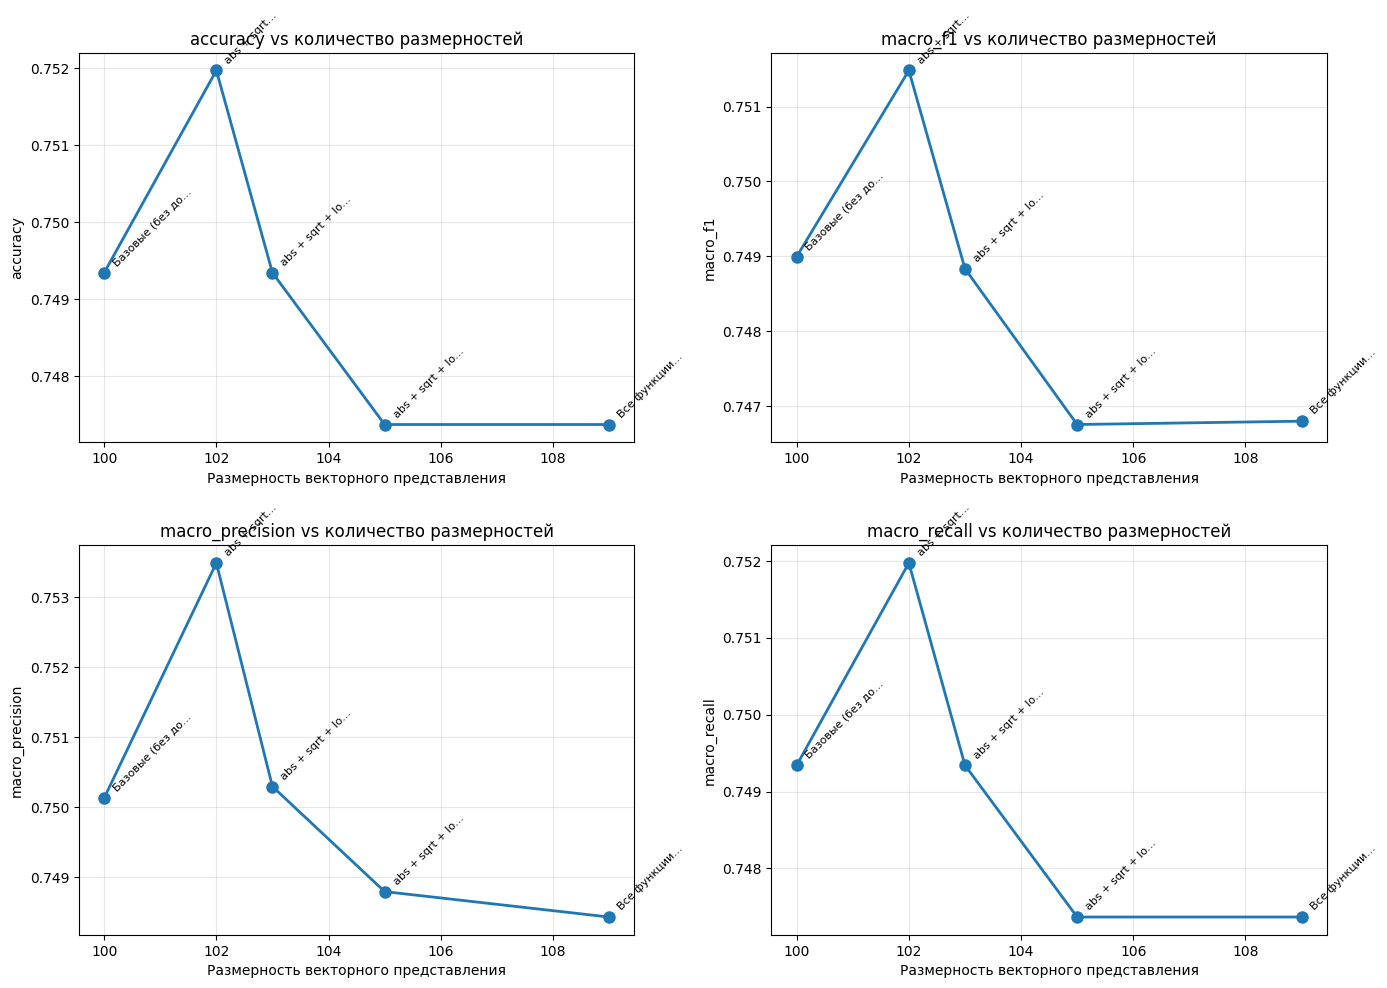

In [13]:

metrics_to_plot = ["accuracy", "macro_f1", "macro_precision", "macro_recall"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    df_sorted = df_math.sort_values("dim")
    
    ax.plot(df_sorted["dim"], df_sorted[metric], marker="o", linewidth=2, markersize=8)
    
    for idx, row in df_sorted.iterrows():
        ax.annotate(
            row["config"][:15] + "...",  
            (row["dim"], row[metric]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            rotation=45
        )
    
    ax.set_xlabel("Размерность векторного представления", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_title(f"{metric} vs количество размерностей", fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [14]:
# Сравнение результатов: базовая модель vs модели с дополнительными размерностями

print("=" * 80)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 80)

base_result = df_math[df_math["config"] == "Базовые (без доп. признаков)"].iloc[0]

print(f"\nБазовая модель (размерность {int(base_result['dim'])}):")
print(f"  Accuracy:      {base_result['accuracy']:.4f}")
print(f"  Macro F1:      {base_result['macro_f1']:.4f}")
print(f"  Macro Precision: {base_result['macro_precision']:.4f}")
print(f"  Macro Recall:  {base_result['macro_recall']:.4f}")

print(f"\nМодели с дополнительными размерностями:")
print("-" * 80)

for idx, row in df_math.iterrows():
    if row["config"] != "Базовые (без доп. признаков)":
        print(f"\n{row['config']} (размерность {int(row['dim'])}):")
        print(f"  Accuracy:      {row['accuracy']:.4f} ({row['accuracy'] - base_result['accuracy']:+.4f})")
        print(f"  Macro F1:      {row['macro_f1']:.4f} ({row['macro_f1'] - base_result['macro_f1']:+.4f})")
        print(f"  Macro Precision: {row['macro_precision']:.4f} ({row['macro_precision'] - base_result['macro_precision']:+.4f})")
        print(f"  Macro Recall:  {row['macro_recall']:.4f} ({row['macro_recall'] - base_result['macro_recall']:+.4f})")

best_math = df_math.sort_values("macro_f1", ascending=False).iloc[0]
print("\n" + "=" * 80)
print(f"Лучшая конфигурация: {best_math['config']}")
print(f"  Размерность: {int(best_math['dim'])}")
print(f"  Macro F1: {best_math['macro_f1']:.4f}")
print("=" * 80)


СРАВНЕНИЕ РЕЗУЛЬТАТОВ

Базовая модель (размерность 100):
  Accuracy:      0.7493
  Macro F1:      0.7490
  Macro Precision: 0.7501
  Macro Recall:  0.7493

Модели с дополнительными размерностями:
--------------------------------------------------------------------------------

abs + sqrt (размерность 102):
  Accuracy:      0.7520 (+0.0026)
  Macro F1:      0.7515 (+0.0025)
  Macro Precision: 0.7535 (+0.0034)
  Macro Recall:  0.7520 (+0.0026)

abs + sqrt + log (размерность 103):
  Accuracy:      0.7493 (+0.0000)
  Macro F1:      0.7488 (-0.0002)
  Macro Precision: 0.7503 (+0.0002)
  Macro Recall:  0.7493 (-0.0000)

abs + sqrt + log + cos + sin (размерность 105):
  Accuracy:      0.7474 (-0.0020)
  Macro F1:      0.7468 (-0.0022)
  Macro Precision: 0.7488 (-0.0013)
  Macro Recall:  0.7474 (-0.0020)

Все функции (размерность 109):
  Accuracy:      0.7474 (-0.0020)
  Macro F1:      0.7468 (-0.0022)
  Macro Precision: 0.7484 (-0.0017)
  Macro Recall:  0.7474 (-0.0020)

Лучшая конфигурация: 

In [15]:

df_math_display = df_math[["config", "dim", "accuracy", "macro_f1", "macro_precision", "macro_recall", "micro_f1"]].copy()

for col in ["accuracy", "macro_f1", "macro_precision", "macro_recall", "micro_f1"]:
    df_math_display[col] = df_math_display[col].round(4)

df_math_display = df_math_display.sort_values("dim")

print("Результаты эксперимента с дополнительными размерностями:")
print("=" * 100)
df_math_display


Результаты эксперимента с дополнительными размерностями:


,config,dim,accuracy,macro_f1,macro_precision,macro_recall,micro_f1
0,Базовые (без доп. признаков),100,0.7493,0.7490,0.7501,0.7493,0.7493
1,abs + sqrt,102,0.7520,0.7515,0.7535,0.7520,0.7520
2,abs + sqrt + log,103,0.7493,0.7488,0.7503,0.7493,0.7493
3,abs + sqrt + log + cos + sin,105,0.7474,0.7468,0.7488,0.7474,0.7474
4,Все функции,109,0.7474,0.7468,0.7484,0.7474,0.7474


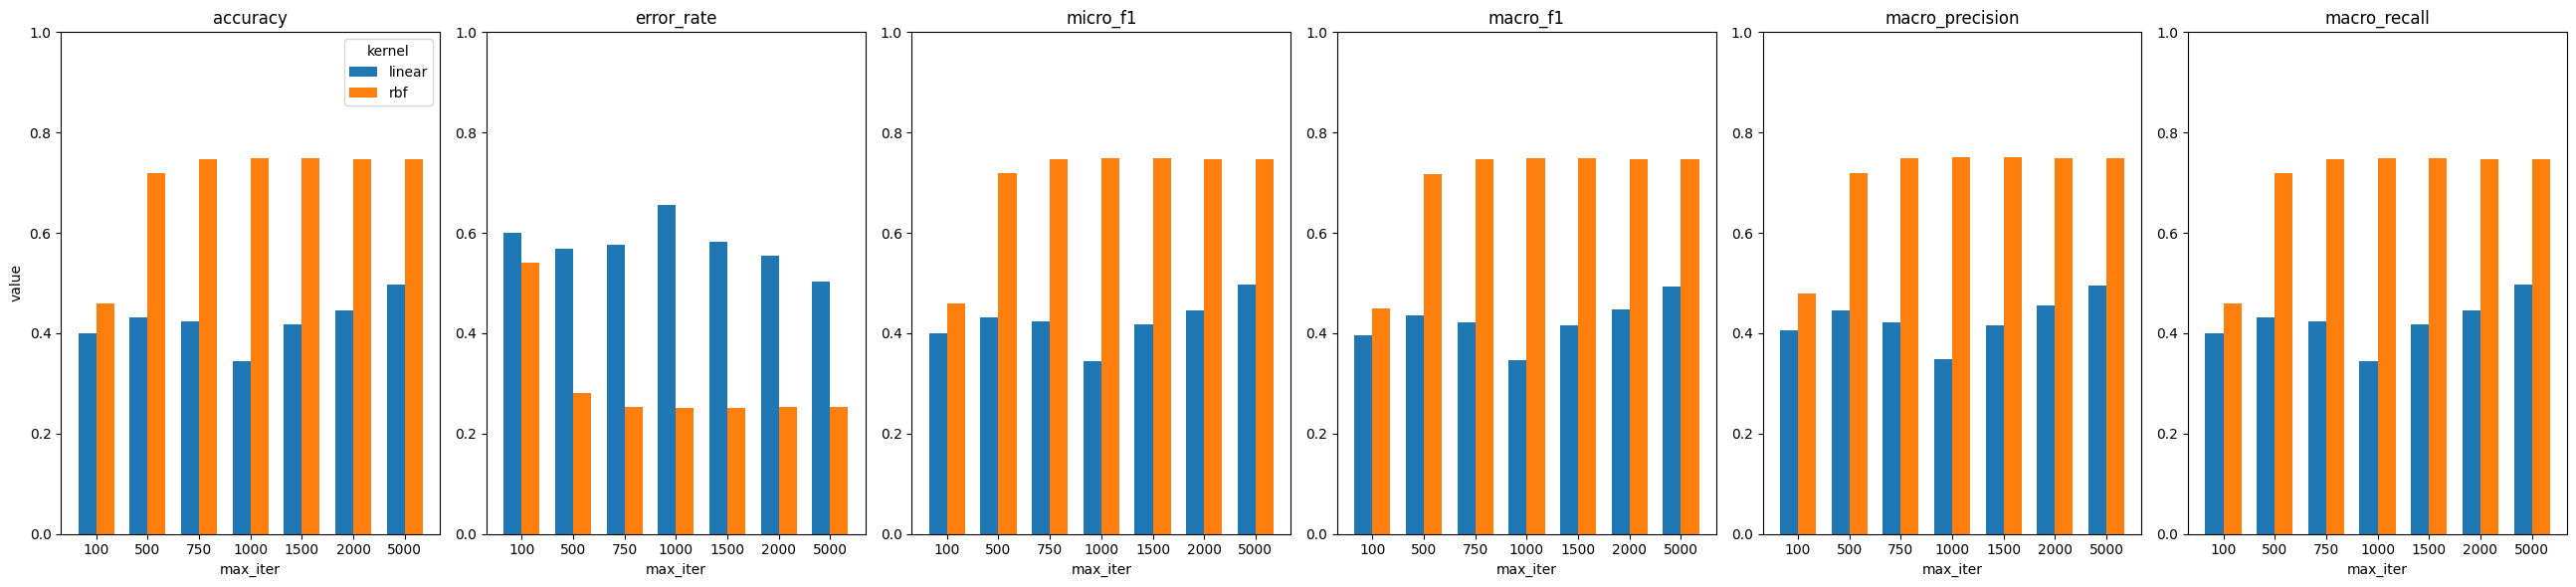

In [17]:
import matplotlib.pyplot as plt
import numpy as np

df = df_results.copy()

df["max_iter"] = df["max_iter"].astype(int)

metrics = ["accuracy", "error_rate", "micro_f1", "macro_f1", "macro_precision", "macro_recall"]
kernels = df["kernel"].unique()
iters = sorted(df["max_iter"].unique())

bar_width = 0.35

fig, axes = plt.subplots(1, len(metrics), figsize=(26, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]

    x = np.arange(len(iters))
    
    for j, kernel in enumerate(kernels):
        subset = df[df["kernel"] == kernel].sort_values("max_iter")

        ax.bar(
            x + j * bar_width,
            subset[metric],
            width=bar_width,
            label=kernel if i == 0 else None
        )

    ax.set_title(metric)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(iters)
    ax.set_xlabel("max_iter")
    ax.set_ylim(0, 1)

axes[0].set_ylabel("value")
axes[0].legend(title="kernel")

plt.tight_layout()
plt.show()


In [23]:
df_results_sorted = df_results.sort_values(["kernel", "max_iter"])
df_results_sorted


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter
0,0.399342,0.600658,0.399342,0.395352,0.405999,0.399342,0.357783,linear,100
1,0.432237,0.567763,0.432237,0.435232,0.445875,0.432237,1.494017,linear,500
2,0.424342,0.575658,0.424342,0.421426,0.421390,0.424342,1.904448,linear,750
3,0.344737,0.655263,0.344737,0.346006,0.348768,0.344737,1.610847,linear,1000
4,0.418421,0.581579,0.418421,0.414780,0.415142,0.418421,1.401247,linear,1500
5,0.446053,0.553947,0.446053,0.447811,0.455025,0.446053,1.974424,linear,2000
6,0.497368,0.502632,0.497368,0.493965,0.495411,0.497368,2.827391,linear,5000
7,0.459211,0.540789,0.459211,0.449683,0.478952,0.459211,0.393657,rbf,100
8,0.718421,0.281579,0.718421,0.717626,0.718811,0.718421,1.585529,rbf,500
9,0.747368,0.252632,0.747368,0.746458,0.749324,0.747368,2.297532,rbf,750


In [21]:
df_report = df_results_sorted.copy()
for col in ["accuracy", "error_rate", "micro_f1", "macro_f1", "macro_precision", "macro_recall"]:
    df_report[col] = df_report[col].round(4)

df_report


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter
0,0.3993,0.6007,0.3993,0.3954,0.4060,0.3993,0.357783,linear,100
1,0.4322,0.5678,0.4322,0.4352,0.4459,0.4322,1.494017,linear,500
2,0.4243,0.5757,0.4243,0.4214,0.4214,0.4243,1.904448,linear,750
3,0.3447,0.6553,0.3447,0.3460,0.3488,0.3447,1.610847,linear,1000
4,0.4184,0.5816,0.4184,0.4148,0.4151,0.4184,1.401247,linear,1500
5,0.4461,0.5539,0.4461,0.4478,0.4550,0.4461,1.974424,linear,2000
6,0.4974,0.5026,0.4974,0.4940,0.4954,0.4974,2.827391,linear,5000
7,0.4592,0.5408,0.4592,0.4497,0.4790,0.4592,0.393657,rbf,100
8,0.7184,0.2816,0.7184,0.7176,0.7188,0.7184,1.585529,rbf,500
9,0.7474,0.2526,0.7474,0.7465,0.7493,0.7474,2.297532,rbf,750
